## Title 
pyGAM with some additions

## Description :

Download and run in own environment.

This notebook is **for the most part exactly the same as Notebook A**, with a a few additions. Those additions are clearly marked in the notebook.

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lecture 5.5 - Smoothers and Generalized Additive Models - Model Fitting

<div class="discussion"><b>JUST A NOTEBOOK + SOME ADDITIONS (see New Material) </b></div>

**Harvard University**<br>
**Spring 2021**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructor:** Eleni Kaxiras<br><BR>
*Content:* Eleni Kaxiras and Will Claybaugh
---

## New material here: 
- [References](#bsplines)
- [info on B-spline basis functions](#basis) 
- [Cleaner formula for csaps](#csaps)

Also cleaner Table of Contents

In [37]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [38]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline 

## Table of Contents

* 1 - Overview - A Top View of LMs, GLMs, and GAMs to set the stage
* 2 - Splines
* 3 - Generative Additive Models with `pyGAM`
* 4 - Smooting Splines using `csaps`
* 5 - Penalized B-splines

## 1 - Overview

![](../images/GAM_venn.png)
*image source: Dani Servén Marín (one of the developers of pyGAM)*

### A - Linear Models

First we have the **Linear Models** which you know from 109a. These models are linear in the coefficients. Very *interpretable* but suffer from high bias because let's face it, few relationships in life are linear. Simple Linear Regression (defined as a model with one predictor) as well as Multiple Linear Regression (more than one predictors) are examples of LMs. Polynomial Regression extends the linear model by adding terms that are still linear for the coefficients but non-linear when it somes to the predictiors which are now raised in a power or multiplied between them.

![](../images/linear.png)

$$
\begin{aligned}
y = \beta{_0} + \beta{_1}{x_1} &  \quad \lparen simple\medspace  linear \medspace regression \rparen \\
y = \beta{_0} + \beta{_1}{x_1} + \beta{_2}{x_2} + \beta{_3}{x_3} &  \quad \lparen multiple\medspace  linear\medspace  regression \rparen \\
y = \beta{_0} + \beta{_1}{x_1} +  \beta{_2}{x_1^2} + \beta{_3}{x_3^3} & \quad \lparen polynomial\medspace  multiple\medspace  regression \rparen\\
\end{aligned}
$$

<div class="discussion"><b>Questions to think about</b></div>

 - What does it mean for a model to be **interpretable**?
 - Are linear regression models interpretable? Are random forests? What about Neural Networks such as Feed Forward? 
 - Do we always want interpretability? Describe cases where we do and cases where we do not care. 


### B - Generalized Linear Models (GLMs)

![](../images/GLM.png)

**Generalized Linear Models** is a term coined in the early 1970s by Nelder and Wedderburn for a class of models that includes both Linear Regression and Logistic Regression. A GLM fits one coefficient per feature (predictor). 

### C - Generalized Additive Models (GAMs)

Hastie and Tidshirani coined the term **Generalized Additive Models** in 1986 for a class of non-linear extensions to Generalized Linear Models.

![](../images/GAM.png)

$$
\begin{aligned}
y = \beta{_0} + f_1\left(x_1\right) + f_2\left(x_2\right) + f_3\left(x_3\right) \\
y = \beta{_0} + f_1\left(x_1\right) + f_2\left(x_2, x_3\right) + f_3\left(x_3\right) &  \lparen with \medspace interaction \medspace terms \rparen 
\end{aligned}
$$

In practice we add splines and regularization via smoothing penalties to our GLMs. 

*image source: Dani Servén Marín*

### D - Basis Functions

In our models we can use various types of functions as "basis". 
- Monomials such as $x^2$, $x^4$ (**Polynomial Regression**)
- Sigmoid functions (neural networks)
- Fourier functions 
- Wavelets 
- Regression splines
- Smoothing splines

## 2 - Piecewise Polynomials a.k.a. Splines

Splines are a type of piecewise polynomial interpolant. A spline of degree k is a piecewise polynomial that is continuously differentiable k − 1 times. 

Splines are the basis of CAD software and vector graphics including a lot of the fonts used in your computer.  The name “spline” comes from a tool used by ship designers to draw smooth curves. Here is the letter $epsilon$ written with splines:

![](../images/epsilon.png)

*font idea inspired by Chris Rycroft (AM205)*

If the degree is 1 then we have a Linear Spline. If it is 3 then we have a Cubic spline. It turns out that cubic splines because they have a continous 2nd derivative (curvature) at the knots are very smooth to the eye. We do not need higher order than that. The Cubic Splines are usually Natural Cubic Splines which means they have the added constrain of the end points' second derivative = 0.

We will use the CubicSpline and the B-Spline as well as the Linear Spline.

#### scipy.interpolate

See all the different splines that scipy.interpolate has to offer: https://docs.scipy.org/doc/scipy/reference/interpolate.html. These routines are based on the FORTRAN library FITPACK written in the '70s.

Let's use the simplest form which is interpolate on a set of points and then find the points between them.

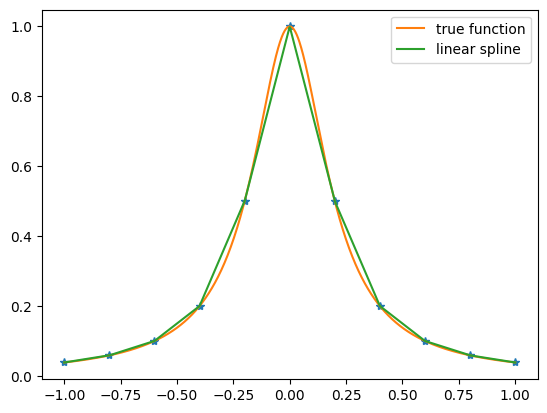

In [39]:
from scipy.interpolate import splrep, splev
from scipy.interpolate import BSpline, CubicSpline
from scipy.interpolate import interp1d

# define the range of the function
a = -1
b = 1

# define the number of knots 
num_knots = 11
# define the knots as equally spaced points
knots = np.linspace(a,b,num_knots)

# define the function we want to approximate
y = 1/(1+25*(knots**2))

# make a linear spline
linspline = interp1d(knots, y)

# sample at these points to plot
xx = np.linspace(a,b,1000)
yy = 1/(1+25*(xx**2))
plt.plot(knots,y,'*')
plt.plot(xx, yy, label='true function')
plt.plot(xx, linspline(xx), label='linear spline');
plt.legend();

<div class="exercise"><b>Exercise</b></div>

The Linear interpolation does not look very good. Fit a Cubic Spline and plot along the Linear to compare. Feel free to solve and then look at the solution.

In [40]:
# your answer here


Num knots in cubic spline: 10


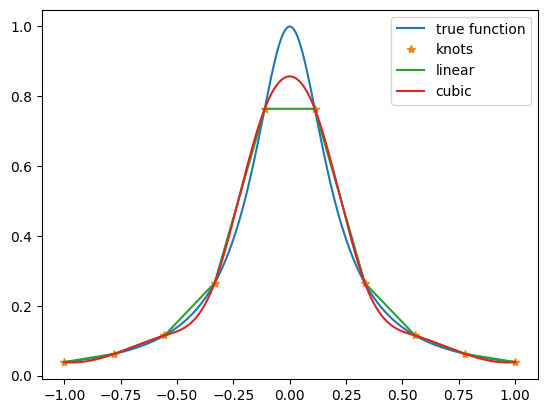

In [41]:
# solution
# define the range of the function
a = -1
b = 1

# define the knots 
num_knots = 10
x = np.linspace(a,b,num_knots)

# define the function we want to approximate
y = 1/(1+25*(x**2))

# make the Cubic spline
cubspline = CubicSpline(x, y)

print(f'Num knots in cubic spline: {num_knots}')

# OR make a linear spline
linspline = interp1d(x, y)

# plot
xx = np.linspace(a,b,10000)
yy = 1/(1+25*(xx**2))

plt.plot(xx, yy, label='true function')
plt.plot(x,y,'*', label='knots')
plt.plot(xx, linspline(xx), label='linear');
plt.plot(xx, cubspline(xx), label='cubic'); 
plt.legend();

<div class="discussion"><b>Questions to think about</b></div>

- Change the number of knots to 100 and see what happens. What would happen if we run a polynomial model of degree equal to the number of knots (a global one as in polynomial regression, not a spline)?
- What makes a spline 'Natural'?

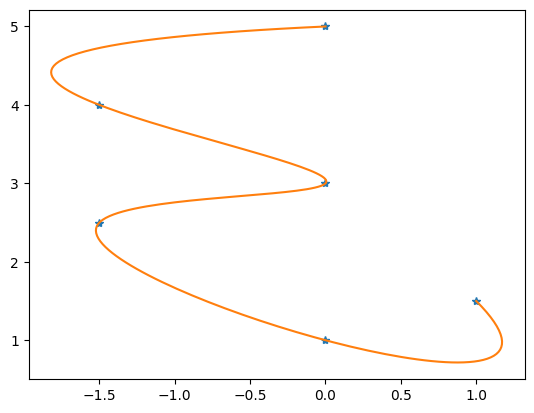

In [42]:
# Optional and Outside of the scope of this class: create the `epsilon` in the figure above
x = np.array([1.,0.,-1.5,0.,-1.5,0.])
y = np.array([1.5,1.,2.5,3,4,5])
t = np.linspace(0,5,6)
f = interp1d(t,x,kind='cubic')
g = interp1d(t,y,kind='cubic')
tplot = np.linspace(0,5,200)
plt.plot(x,y, '*', f(tplot), g(tplot));

#### B-Splines (Curry and Schoenberg(1966) , further study by de Boor, 1978)

One way to construct a curve given a set of points is to *interpolate the points*, that is, to force the curve to pass through the points.

A B-splines (Basis Splines) is defined by a set of **control points** and a set of **basis functions** that fit the function between these points. By choosing to have no smoothing factor we force the final B-spline to pass though all the points. If, on the other hand, we set a smothing factor, our function is more of an approximation with the control points as "guidance". The latter produced a smoother curve which is prefferable for drawing software. For more on Splines see:  https://en.wikipedia.org/wiki/B-spline) or for a deeper look: *De Boor, C. (1978). A practical guide to splines (Applied mathematical sciences (Springer-Verlag New York Inc.) ; v. 27). New York: Springer-Verlag*.

![](../images/B-spline.png)

We will use [`scipy.splrep`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep) to calulate the coefficients for the B-Spline and draw it. 

#### B-Spline with no smooting

In [43]:
0.1e+01

1.0

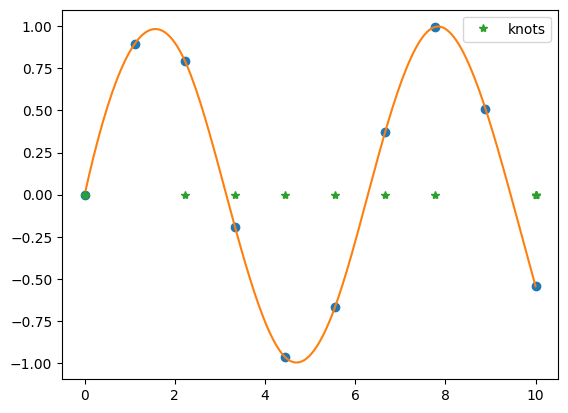

In [44]:
from scipy.interpolate import splev, splrep

x = np.linspace(0, 10, 10)
y = np.sin(x)
# (t,c,k) is a tuple containing the vector of knots, coefficients, degree of the spline
t,c,k = splrep(x, y) 
x2 = np.linspace(0, 10, 200)
y2 = BSpline(t,c,k)
plt.plot(x, y, 'o', x2, y2(x2))
plt.plot(t, np.zeros(len(t)), '*', label='knots')
plt.legend()
plt.show()

In [45]:
len(x), t,len(t), len(c), k

(10,
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  2.22222222,
         3.33333333,  4.44444444,  5.55555556,  6.66666667,  7.77777778,
        10.        , 10.        , 10.        , 10.        ]),
 14,
 14,
 3)

Knots (14 of them): [ 0.          0.          0.          0.          2.22222222  3.33333333
  4.44444444  5.55555556  6.66666667  7.77777778 10.         10.
 10.         10.        ]

B-Spline coefficients (14 of them): [-4.94881722e-18  8.96543619e-01  1.39407154e+00 -2.36640266e-01
 -1.18324030e+00 -8.16301228e-01  4.57836125e-01  1.48720677e+00
  1.64338775e-01 -5.44021111e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]

B-Spline degree 3


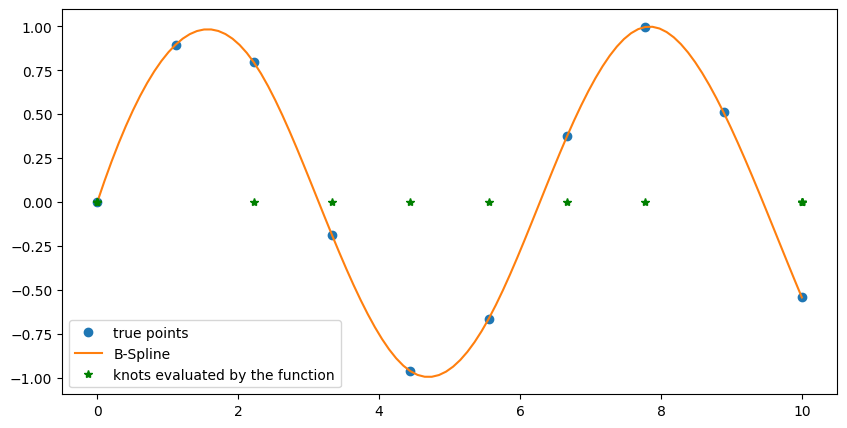

In [46]:
from scipy.interpolate import splrep
x = np.linspace(0, 10, 10)
y = np.sin(x)

# (tck) is a tuple containing the vector of knots, 
# coefficients, degree of the spline
t,c,k = splrep(x, y, k=3) 
# define the points to plot on (x2)
print(f'Knots ({len(t)} of them): {t}\n')
print(f'B-Spline coefficients ({len(c)} of them): {c}\n') 
print(f'B-Spline degree {k}')
x2 = np.linspace(0, 10, 100)
y2 = BSpline(t, c, k)
plt.figure(figsize=(10,5))
plt.plot(x, y, 'o', label='true points')
plt.plot(x2, y2(x2), label='B-Spline')
tt = np.zeros(len(t))
plt.plot(t, tt,'g*', label='knots evaluated by the function')
plt.legend()
plt.show()

<a id=splineparams></a> 
#### What do the tuple values returned by `scipy.splrep`  mean?

- The `t` variable is the array that contains the knots' position in the x axis. The length of this array is, of course, the number of knots.
- The `c` variable is the array that holds the coefficients for the B-Spline. Its length should be the same as `t`.

We have `number_of_knots - 1` B-spline basis elements to the spline constructed via this method, and they are defined as follows:<BR><BR>
$$
\begin{aligned}
B_{i, 0}(x) = 1, \textrm{if $t_i \le x < t_{i+1}$, otherwise $0$,} \\ \\
B_{i, k}(x) = \frac{x - t_i}{t_{i+k} - t_i} B_{i, k-1}(x)
                 + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} B_{i+1, k-1}(x)
\end{aligned}
$$           
- `t` $\in [t_1, t_2, ..., t_n]$ is the knot vector
- `c` : are the spline coefficients
- `k` : is the spline degree
  

<a id=bsplines></a> 
#### References: 
- [All you wanted to know about B-Splines](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep) and were afraid to ask, or how `scipy.splrep` calculates B-spline representations.
- For more on the [basis of B-splines](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BSpline.html).
- [scipy.interpolate.BSpline.basis_element](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BSpline.basis_element.html#scipy.interpolate.BSpline.basis_element).
- Inside the documentation you will find references to books.

In [47]:
from scipy.interpolate import splev, splrep
from scipy.interpolate import BSpline

<a id=basis></a> 
#### Constructing the B-spline basis elements

The degree of the B-spline, `k`, is inferred from the length of `t` as `len(t)-2`. The knot vector is constructed by appending and prepending `k+1` elements to internal knots `t`.

a) The first element is a B-spline of degree $d=0$ with $1$ knot (min number of knots = $d+2$)

$$(d=0), B_{i, 0}(x) = 1, \textrm{if $t_i \le x < t_{i+1}$, otherwise $0$, (0 interior knots, 2 total)}$$

b) The second element is a B-spline of degree $d=1$ with $2$ knots

$$(d=1), B_{i, 0}(x) = 1, \textrm{if $t_i \le x < t_{i+1}$, otherwise $0$, (1 interior knot, 3 total)}$$

and so on ...

Knots for b3 = [0. 1. 2. 3. 4.]
Augmented knots for b3 = [-1. -1. -1.  0.  1.  2.  3.  4.  5.  5.  5.]


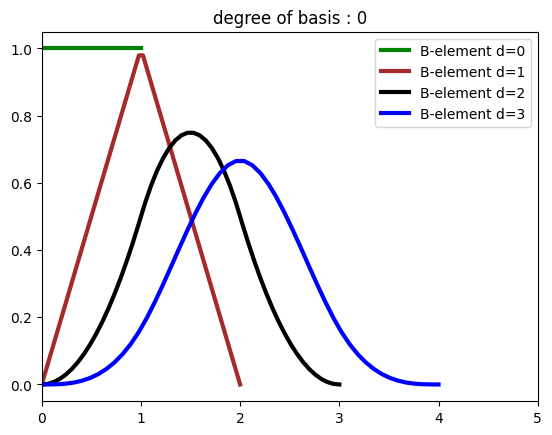

In [48]:
b0 = BSpline.basis_element([0,1]) # two knots are the boundary nodes with 0 internal knots 
b1 = BSpline.basis_element([0,1,2])
b2 = BSpline.basis_element([0,1,2,3])
b3 = BSpline.basis_element([0,1,2,3,4])
print(f'Knots for b3 = {b3.t[3:-3]}')
# B-splines add knots before and after the boundaries for better construction.
print(f'Augmented knots for b3 = {b3.t}')
fig, ax = plt.subplots()
x0 = np.linspace(0, 1, 50)
x1 = np.linspace(0, 2, 50)
x2 = np.linspace(0, 3, 50)
x3 = np.linspace(0, 4, 50)
ax.set_xlim(0,5);
ax.set_title(f'degree of basis : {b0.k}')
ax.plot(x0, b0(x0), 'g', label=f'B-element d={b0.k}', lw=3);
ax.plot(x1, b1(x1), 'brown', label=f'B-element d={b1.k}', lw=3);
ax.plot(x2, b2(x2), 'black', label=f'B-element d={b2.k}', lw=3);
ax.plot(x3, b3(x3), 'blue', label=f'B-element d={b3.k}', lw=3);
ax.legend();

#### B-Spline with smooting factor s

In [49]:
x = np.linspace(0, 10, 5)
y = np.sin(x)

s = 0.1 # add smoothing factor
# task needs to be set to 0, which represents:
# we are specifying a smoothing factor and thus only want
# splrep() to find the optimal t and c
task = 0 

t,c,k = splrep(x, y, task=task, s=s)
print(f'Knots ({len(t)}): {t}, {k}')

Knots (9): [ 0.  0.  0.  0.  5. 10. 10. 10. 10.], 3


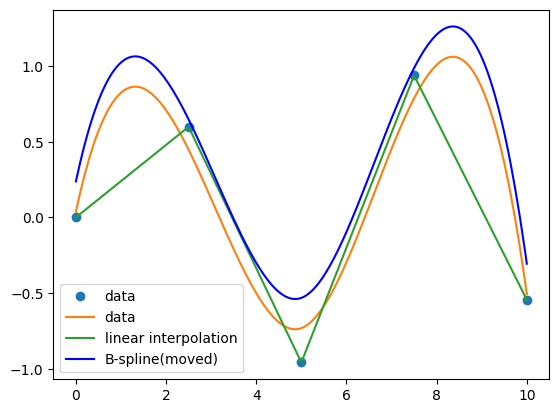

In [50]:
# draw the line segments
linspline = interp1d(x, y)
# define the points to plot on (x2)
x2 = np.linspace(0, 10, 200)
y2 = BSpline(t, c, k)
plt.plot(x, y, 'o', x2, y2(x2), label='data')
plt.plot(x2, linspline(x2), label='linear interpolation')
#+0.2 is pertubating the line for visibility
plt.plot(x2, y2(x2)+0.2, 'blue', label='B-spline(moved)') 
plt.legend()
plt.show()

#### B-Spline with given knots

In [51]:
x = np.linspace(0, 10, 100)
y = np.sin(x)
# ‘quantile’ knot sequence: the interior knots are the quantiles from the empirical 
# distribution of the underlying variable. Quantile knots guarantee that each 
# interval contains an equal number of sample observations
knots = np.quantile(x, [0.25, 0.5, 0.75])
print(knots)

[2.5 5.  7.5]


In [52]:
# calculate the B-Spline
t,c,k = splrep(x, y, t=knots)

In [53]:
t

array([ 0. ,  0. ,  0. ,  0. ,  2.5,  5. ,  7.5, 10. , 10. , 10. , 10. ])

In [54]:
curve = BSpline(t,c,k)
curve

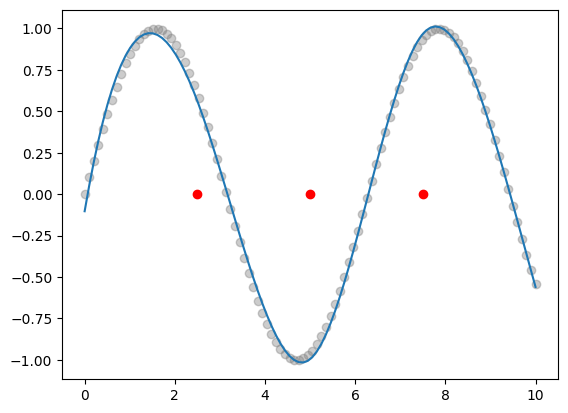

In [55]:
plt.scatter(x=x,y=y,c='grey', alpha=0.4)
yknots = np.sin(knots)
#plt.scatter(knots, yknots, c='r')
plt.scatter(knots, np.zeros(len(yknots)), c='r')
plt.plot(x,curve(x))
plt.show()

## 3 - GAMs

https://readthedocs.org/projects/pygam/downloads/pdf/latest/

#### Classification in `pyGAM`

Let's get our (multivariate!) data, the `kyphosis` dataset, and the `LogisticGAM` model from `pyGAM` to do binary classification.

- kyphosis - wherther a particular deformation was present post-operation
- age - patient's age in months
- number - the number of vertebrae involved in the operation
- start - the number of the topmost vertebrae operated on

In [56]:
kyphosis = pd.read_csv("../data/kyphosis.csv")

display(kyphosis.head())
display(kyphosis.describe(include='all'))
display(kyphosis.dtypes)

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


,Kyphosis,Age,Number,Start
count,81,81.000000,81.000000,81.000000
unique,2,NaN,NaN,NaN
top,absent,NaN,NaN,NaN
freq,64,NaN,NaN,NaN
mean,NaN,83.654321,4.049383,11.493827
std,NaN,58.104251,1.619423,4.883962
min,NaN,1.000000,2.000000,1.000000
25%,NaN,26.000000,3.000000,9.000000
50%,NaN,87.000000,4.000000,13.000000
75%,NaN,130.000000,5.000000,16.000000


Kyphosis    object
Age          int64
Number       int64
Start        int64
dtype: object

In [57]:
# convert the outcome in a binary form, 1 or 0
kyphosis = pd.read_csv("../data/kyphosis.csv")
kyphosis["outcome"] = 1*(kyphosis["Kyphosis"] == "present")
kyphosis.describe()

,Age,Number,Start,outcome
count,81.000000,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827,0.209877
std,58.104251,1.619423,4.883962,0.409758
min,1.000000,2.000000,1.000000,0.000000
25%,26.000000,3.000000,9.000000,0.000000
50%,87.000000,4.000000,13.000000,0.000000
75%,130.000000,5.000000,16.000000,0.000000
max,206.000000,10.000000,18.000000,1.000000


In [58]:
kyphosis

,Kyphosis,Age,Number,Start,outcome
0,absent,71,3,5,0
1,absent,158,3,14,0
2,present,128,4,5,1
3,absent,2,5,1,0
4,absent,1,4,15,0
...,...,...,...,...,...
76,present,157,3,13,1
77,absent,26,7,13,0
78,absent,120,2,13,0
79,present,42,7,6,1


In [59]:
from pygam import LogisticGAM, s, f, l

X = kyphosis[["Age","Number","Start"]]
y = kyphosis["outcome"]
kyph_gam = LogisticGAM().fit(X,y)

#### Outcome dependence on features

To help us see how the outcome depends on each feature, `pyGAM` has the `partial_dependence()` function.
```
 pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
```
For more on this see the : https://pygam.readthedocs.io/en/latest/api/logisticgam.html


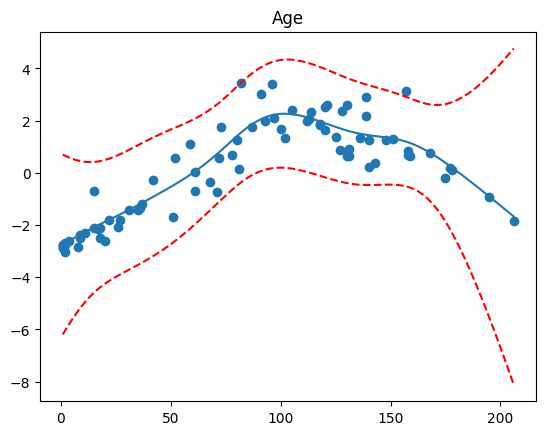

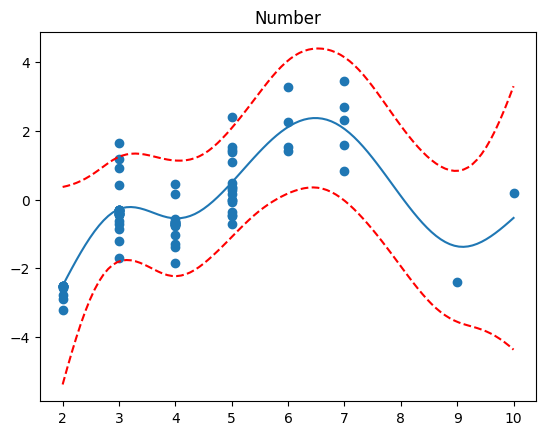

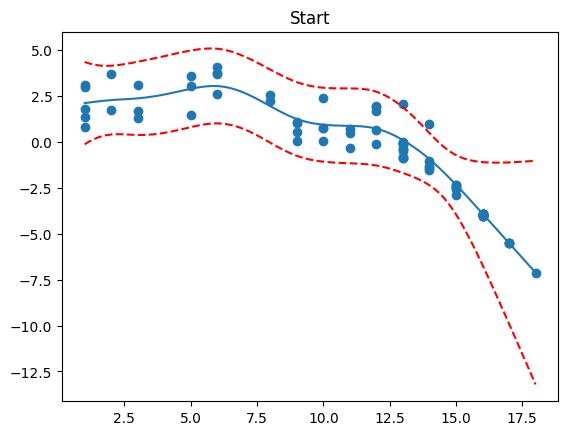

In [60]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

Notice that we did not specify the basis functions in the .fit(). `pyGAM` figures them out for us by using $s()$ (splines) for numerical variables and $f()$ for categorical features. If this is not what we want we can manually specify the basis functions, as follows: 

In [61]:
kyph_gam = LogisticGAM(s(0)+s(1)+s(2)).fit(X,y)

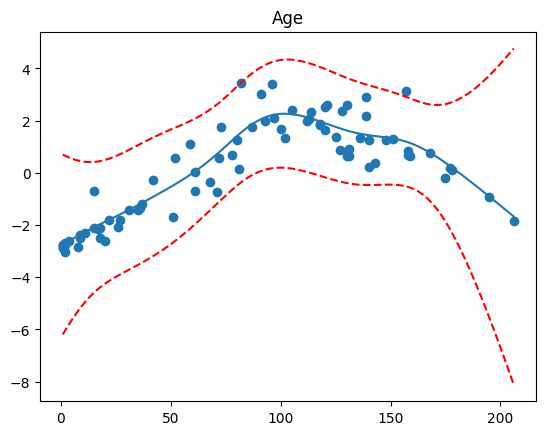

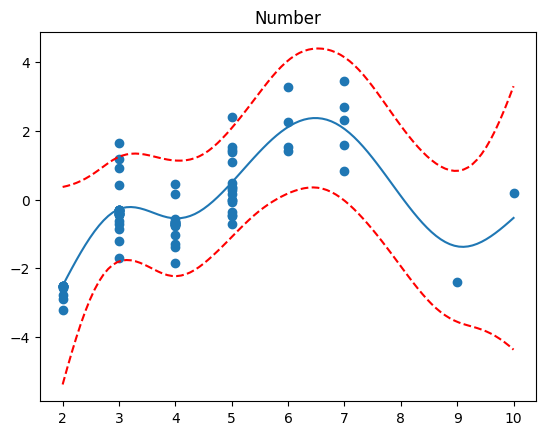

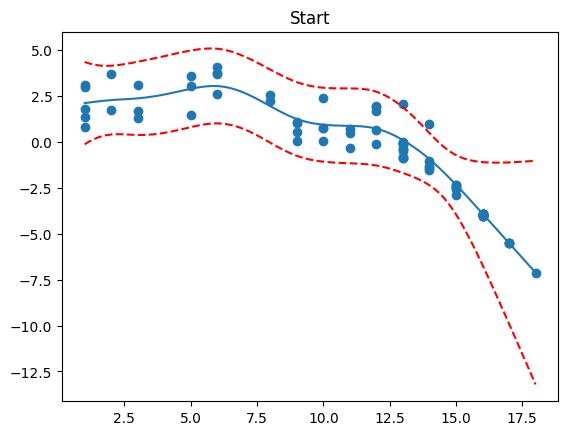

In [62]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

#### Regression in `pyGAM`

For regression problems, we can use a `linearGAM` model. For this part we will use the `wages` dataset.

https://pygam.readthedocs.io/en/latest/api/lineargam.html

#### The `wages` dataset

Let's inspect another dataset that is included in `pyGAM` that notes the wages of people based on their age, year of employment and education.

In [63]:
from pygam.utils import make_2d

def _clean_X_y(X, y):
    """Ensure that X and y data are float and correct shapes."""
    return make_2d(X, verbose=False).astype("float"), y.astype("float")


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:08
 18% (2 of 11) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:08
 27% (3 of 11) |######                   | Elapsed Time: 0:00:02 ETA:   0:00:06
 36% (4 of 11) |#########                | Elapsed Time: 0:00:02 ETA:   0:00:04
 45% (5 of 11) |###########              | Elapsed Time: 0:00:03 ETA:   0:00:03
 54% (6 of 11) |#############            | Elapsed Time: 0:00:03 ETA:   0:00:02
 63% (7 of 11) |###############          | Elapsed Time: 0:00:03 ETA:   0:00:02
 72% (8 of 11) |##################       | Elapsed Time: 0:00:04 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:04 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:04 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


<Figure size 640x480 with 0 Axes>

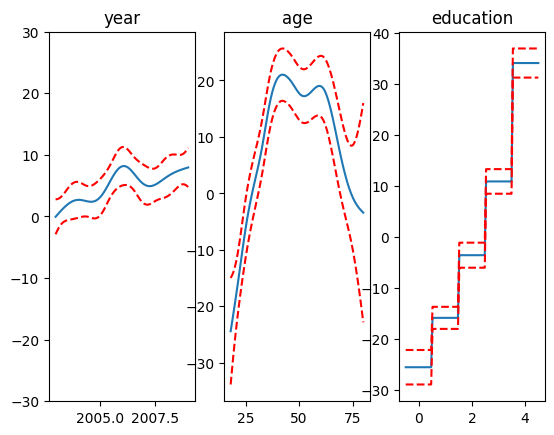

In [ ]:
# from the pyGAM documentation
from pygam import LinearGAM, s, f
from pygam.datasets import wage

df = pd.read_csv('../data/Wage.csv')
wage = df.iloc[:, :-1]
# format X to contain the year, age and education of each sampled person.
# The education category has been transformed to integers
X = wage[["year", "age", "education"]].values
X[:, -1] = np.unique(X[:, -1], return_inverse=True)[1]
y = df.iloc[:, -1]
X, y = _clean_X_y(X, y)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

<a id=csaps></a> 
## 4 - Smoothing Splines using csaps

A smoothing spline is a solution of the problem of minimizing the *goodness-of-fit* and the *smoothing (wiggliness).* <BR>
$MSE - \lambda\cdot\text{wiggle penalty}$ $=$ $p\sum_{i=1}^N \left(y_i - f(x_i)\right)^2 + (1-p) \int \left(f''(t)\right)^2 dt$, <BR>
across all possible functions $f$. 
    
The p smoothing parameter is in the range of [0,1] with 0 giving you: the smoothing spline which is the least-squares straight line fit to the data, and 1: the natural cubic spline interpolant.

(1000,)


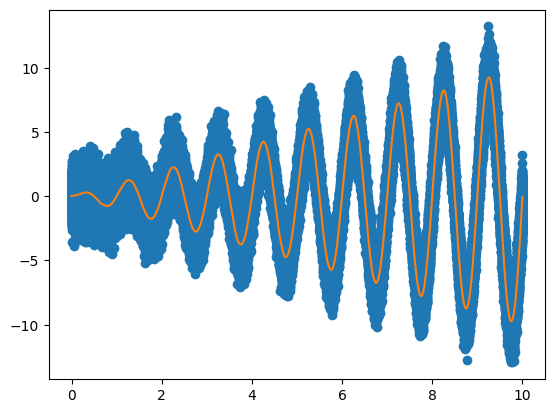

In [65]:
from csaps import csaps

np.random.seed(1234)

x = np.linspace(0,10,300000)
y = np.sin(x*2*np.pi)*x + np.random.randn(len(x))

xs = np.linspace(x[0], x[-1], 1000)

ys = csaps(x, y, xs, smooth=0.99)
print(ys.shape)

plt.plot(x, y, 'o', xs, ys, '-')
plt.show()

## 5 - Data fitting using pyGAM and Penalized B-Splines

When we use a spline in pyGAM we are effectively using a penalized B-Spline with a regularization parameter $\lambda$. E.g. 
```
LogisticGAM(s(0)+s(1, lam=0.5)+s(2)).fit(X,y) 
```

Let's see how this smoothing works in `pyGAM`. We start by creating some arbitrary data and fitting them with a GAM. The lambda parameter (lam) goes from 0 to infinity. The default for the LinearGAM, is 0.6. 

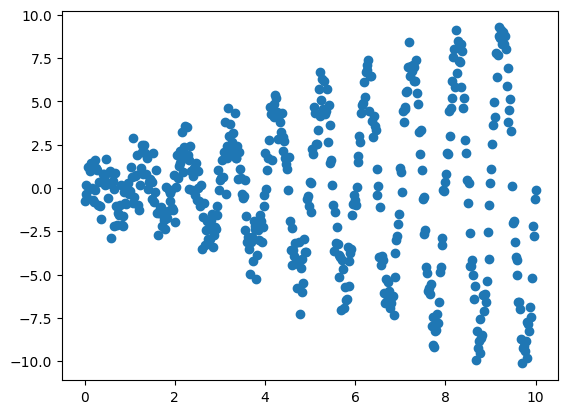

In [66]:
X = np.linspace(0,10,500)
y = np.sin(X*2*np.pi)*X + np.random.randn(len(X))

plt.scatter(X,y);

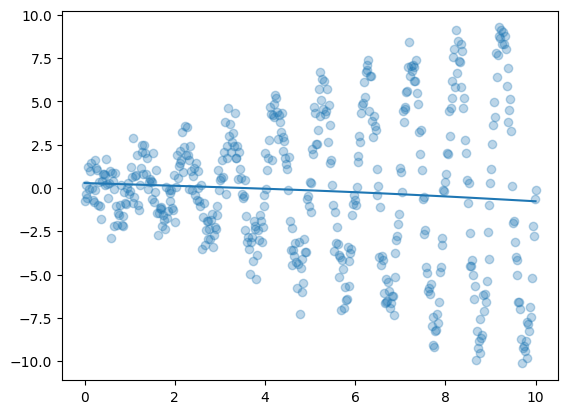

In [67]:
# let's try a large lambda first and lots of splines
gam = LinearGAM(lam=1e6, n_splines=50). fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3);
plt.plot(XX, gam.predict(XX));

We see that the large $\lambda$ forces a straight line, no flexibility. Let's see now what happens if we make it smaller.

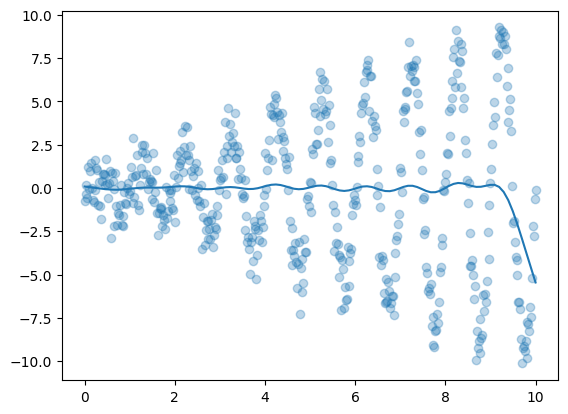

In [68]:
# let's try a smaller lambda 
gam = LinearGAM(lam=1e2, n_splines=50). fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3);
plt.plot(XX, gam.predict(XX));

There is some curvature there but still not a good fit. Let's try no penalty. That should have the line fit exactly.

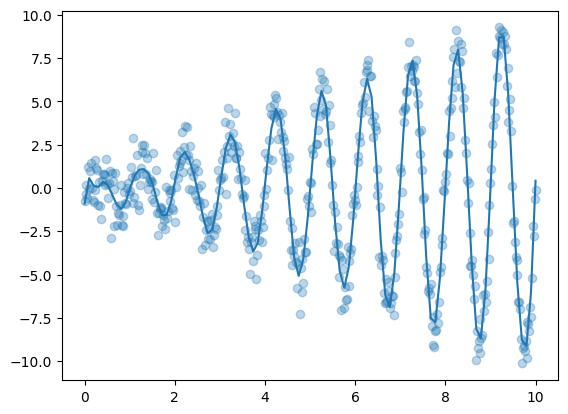

In [69]:
# no penalty, let's try a 0 lambda 
gam = LinearGAM(lam=0, n_splines=50). fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3)
plt.plot(XX, gam.predict(XX));

Yes, that is good. Now let's see what happens if we lessen the number of splines. The fit should not be as good.

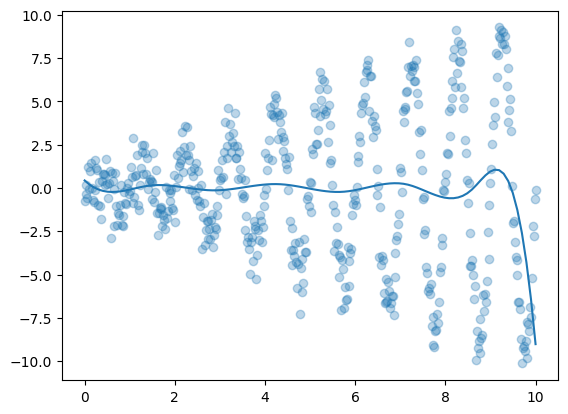

In [70]:
# no penalty, let's try a 0 lambda 
gam = LinearGAM(lam=0, n_splines=10).fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3);
plt.plot(XX, gam.predict(XX));

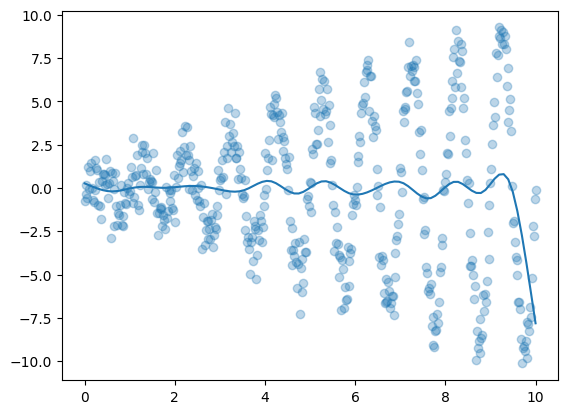

In [71]:
# no penalty, let's try a 0 lambda 
gam = LinearGAM().fit(X,y)
XX = gam.generate_X_grid(term=0)
plt.scatter(X,y,alpha=0.3);
plt.plot(XX, gam.predict(XX));